# Comparison between original model and model with delay

Acapacidade média de atendimento por passo em cada um dos modelos comparados deve ser a mesma. Para isso, o número máxmio de servidores no caso com atraso deve ser igual a $S_d$

$$S_d = t_m \cdot S_o$$

onde $t_m$ é o tempo médio de serviço (1+atraso), $S_o$ é o número de servidores no modelo original sem atrasos.

Para um atraso máximo no serviço de 3 passos ($t_{serM} = 3$), com atrasos distribuidos de maneira uniforme, o $t_m$ seria igual a 3. Para que a comparação seja válida, é necessário que $t_m$ seja um inteiro. Para que isso ocorra, $t_serM$ deve ser ímpar.

$$t_m = \frac{((t_{serM}+1)(t_{serM}+2)/2)-1}{t_{serM}} = \frac{2+3+4}{3} = 3 $$

In [1]:
using JuMP
using HiGHS
using Ipopt
using Juniper

include("utils.jl") # demand_generator_mat, printTable, plotData
include("optimize_list.jl")

### Comon Parametrers

In [2]:
# Parameters
N = 5            # number of examples
horiz = 20       # total horizon

createDemands = true

module def_params
    # bounds
    XM = 8            # max queue length 5
    YM = 10           # max buffer length before dropping calls
    phiM = 9          # max adimission to queue
    serMo = 7         # max number of servers original model
    tserM = 3         # max delay in service time

    # iniital conditions
    X0 = 4
    Y0 = 6
    L0 = 0
    Z0 = 1

    tm = (((tserM+1)*(tserM+2)/2)-1)/tserM # average service time
    serMd = Int(serMo*tm)                  # max number of servers model with delay
    
    # Non-linear objective function costs
    c_blr_nd = 400
    c_ser_nd = 1

    # Linear objective function costs
    c_z_d = 3/2*c_ser_nd/tm    # weight of served clients      
    c_ser_d = c_ser_nd/tm      # weight of server cost
    c_L_d = 1/2*c_ser_nd/tm

    
    struct bounds
        XM
        YM
        phiM
        serM  # different for each model
        tserM # only defined for the model with delay
    end

    bds_nd = bounds(XM, YM, phiM, serMo, 0)
    bds_d = bounds(XM, YM, phiM, serMd, tserM)

    struct initial_conditions
        X0
        Y0
        L0
        Z0
    end
    ic = initial_conditions(X0, Y0, L0, Z0)

    struct c
        z
        L
        ser
        blr
    end

    c_nd = c(0, 0, c_ser_nd, c_blr_nd)  # original model costs
    c_d = c(c_z_d, c_L_d, c_ser_d, c_blr_nd)  # model with delay costs

    export ic, bds_nd, bds_d, tm, c_nd, c_d 
end
using .def_params



if createDemands
    d_mat = demand_generator_mat(N, horiz, 14, "uniform", 1)
    a_mat = demand_generator_mat(N, horiz, 1, "uniform", 0.5)
else
    d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
    a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";
    d_mat = DelimitedFiles.readdlm(d_fn);
    a_mat = DelimitedFiles.readdlm(a_fn);
end



df_input = df_input_generator(horiz, bds_d.serM, bds_d.tserM);

### Original model results

In [3]:
result_os_nd = optimize_list("nd_os");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

LOCALLY_INFEASIBLE
[1.0, 1.0, 0.0, 1.0, 1.0]

In [4]:
# include("cc_no_delay_om.jl")
# include("optimize_list.jl")
# result_om_nd = optimize_list("nd_om");

### Delay model results

In [5]:
include("cc_delay_os.jl")
result_os_d = optimize_list("d_os");

INFEASIBLE
[1.0, 1.0, 0.0, 1.0, 1.0]

In [6]:
# result_om_d = optimize_list("d_om");

## Results comparison

In [19]:
results_list = [result_os_nd, result_os_d]

for res in results_list
    br = sum(res.L./(res.L.+res.Z))/(N*horiz) 

    total_clients = sum(res.Z[:,horiz+1])/N

    cost = res.c.ser*sum(res.Ser)/(N*horiz) + res.c.blr*br

    Ser = sum(res.Ser)/(N*horiz)
    dr = sum(res.dr)/(N*horiz)

    println("blr:", br*res.c.blr)
    println("ser:", Ser*res.c.ser)


    println(res.id)
    data = hcat(br, total_clients, dr, Ser, cost)
    header = (["average blr", "Average served clients", "Average dropped", "Average active Servers", "Average cost"]);
    printTable(data, header)
end

blr:86.91246673405556
ser:4.35
nd_os
Results
┌─────────────┬────────────────────────┬─────────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Average dropped │ Average active Servers │ Average cost │
├─────────────┼────────────────────────┼─────────────────┼────────────────────────┼──────────────┤
│       0.217 │                 88.000 │           0.950 │                  4.350 │       91.262 │
└─────────────┴────────────────────────┴─────────────────┴────────────────────────┴──────────────┘
blr:NaN
ser:4.47
d_os
Results
┌─────────────┬────────────────────────┬─────────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Average dropped │ Average active Servers │ Average cost │
├─────────────┼────────────────────────┼─────────────────┼────────────────────────┼──────────────┤
│         NaN │                 81.000 │           0.720 │                 13.410 │          NaN │
└─────────────┴───────────────────

nd_os


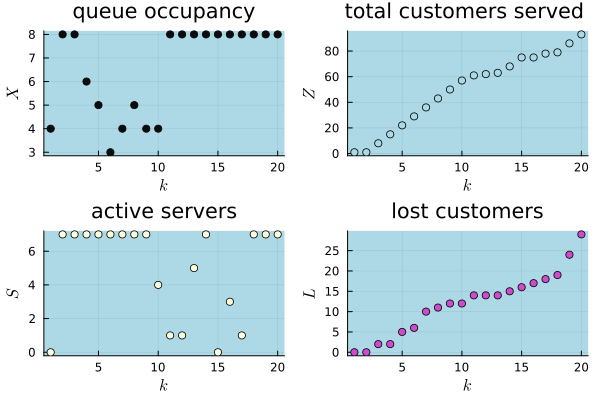

In [7]:
plot_results(result_os_nd, horiz, 1)

In [13]:
# plot_results(result_om_nd, horiz, 1)

d_os


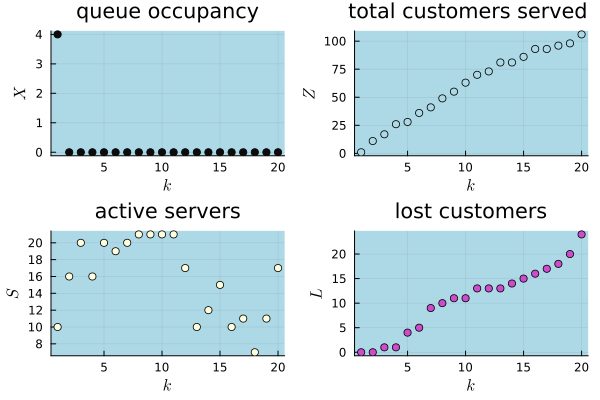

In [8]:
plot_results(result_os_d, horiz, 1)

In [101]:
function plot_results2(res, horiz, i)
    println(res.id)
    evolution = [res.Cin[i, 1:horiz], res.X[i, 1:horiz], a_mat[1:horiz, i], res.L[i, 1:horiz]]
    ylabel = [L"X" L"Z" L"S" L"L"]
    title = ["dropped" "queue" "abandoned" "lost customers"]
    plotData(evolution, ylabel, title)
end

plot_results2 (generic function with 1 method)

d_os_copy


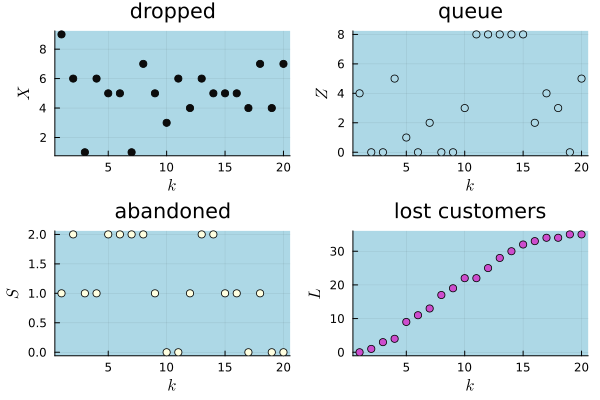

In [102]:
plot_results2(result_os_d_copy, horiz, 1)

In [62]:
function check_results(res, a, d)
    for i in 1:N
        if res.status_opt[i] == 0
            println("The optimization problem n ", i," did not solve to optimality.")
        else
            for t in 1:horiz
                @assert res.X[i,t+1] == res.X[i,t] + res.phi[i,t] - a[t,i] - res.Cin[i,t]
                @assert res.Y[i,t+1] == res.Y[i,t] + res.Q[i,t] - res.phi[i,t]
                @assert res.Z[i,t+1] == res.Z[i,t] + res.Cin[i,t]
                @assert res.L[i,t+1] == res.L[i,t] + res.dr[i,t] + a[t,i]
                @assert res.Cin[i,t] == sum(res.Sl[i,t,:])
            end
        end
    end
    println("All constraints are satisfied")
end

check_results (generic function with 1 method)

In [2]:
sum(ones(2,2))

4.0